<a href="https://colab.research.google.com/github/LithiraHettiarachchi/gestureRecognitionCNN/blob/main/Gesture_Recognition_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

**Extract Dataset**


MNIST Hand gesture image dataset will be use train the model. This dataset contains two seperate files for traing and testing data.                            

In [ ]:
train_set_file_path = '/content/drive/My Drive/Applied AI/Coursework/MNIST_Gesture/sign_mnist_train.csv'
test_set_file_path = '/content/drive/My Drive/Applied AI/Coursework/MNIST_Gesture/sign_mnist_test.csv'

In [ ]:
train_df = pd.read_csv(train_set_file_path)
test_df = pd.read_csv(test_set_file_path)

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


**Start Preprocessing**
1. Check if all the labales have roughly same amount of data.
2. Handling missing values.

First we will check if the dataset contatins any null or missing values.



In [ ]:
train_df.isnull().sum()

,0
label,0
pixel1,0
pixel2,0
pixel3,0
pixel4,0
...,...
pixel780,0
pixel781,0
pixel782,0
pixel783,0


In [ ]:
train_df.isnull().any().any()

False

In [ ]:
#Separating training labels and images
train_images = train_df.drop('label', axis=1).values
train_labels = train_df['label'].values

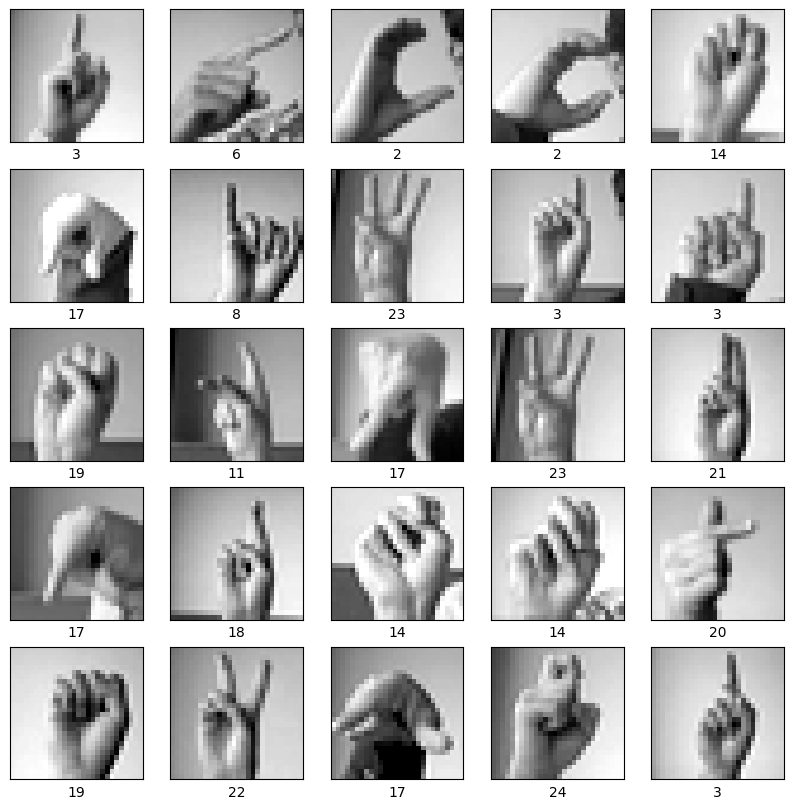

In [ ]:
#Plot 25 images
class_names = np.unique(train_labels)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
print(train_df.shape)
print(test_df.shape)

(27455, 785)
(7172, 785)


Accoding to the train and test dataframe shapes we can see train and test data has splitted roughly 80% 20%.

27455 + 7172 = 34627

34627 * 0.8 = 27701

34627 * 0.2 = 6925

The test data is a separate df. It will use to test the modeil for final. The training df which has 27455 records will devide into 80/20 ratio and the test set(20% from total) will then devide into 10% , 10% for initial testing and validation.

<Axes: ylabel='count'>

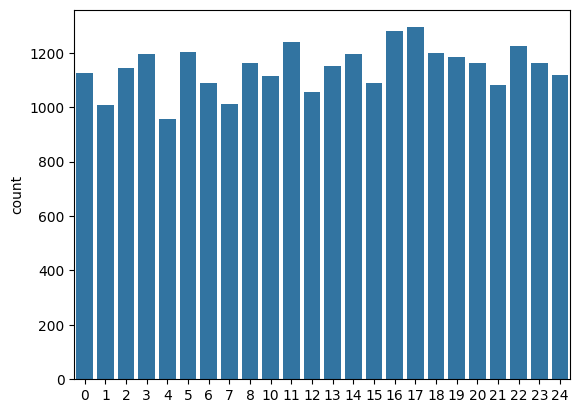

In [ ]:
sns.countplot(x=train_labels)

According to the seaborn countplot the dataset have 24 unique labels. Each lable has racords starting from 850+  to 1200+. We can say this dataset is roughly balanced dataset.

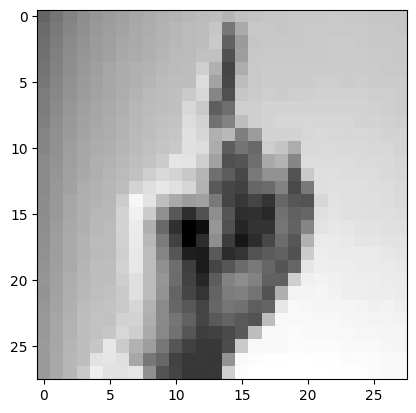

In [ ]:
#Extract images from csv file. Need to reshape the images for object recognition task
#The pixels in the csv file is now in 1D array format. So we need to convert it to 2D shape.
images_2D_format = np.array([np.reshape(i, (28, 28)) for i in train_images])
flatten_images = np.array([i.flatten() for i in images_2D_format])

plt.imshow(images_2D_format[0], cmap='gray')
plt.show()

In [ ]:
#Since the labels are categorical we need to encode it too.
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(train_labels)
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

Now we will divide training data into 3 phases.
Training data, Testing data and Validation data.

For this we will use Flatten images and encoded labels. First the data will divide into 80% of training data and 20% of tempory data. Then that 20% temp data will divide by 50%. Now the validation images and testing images are 10% from the total dataset.


In [ ]:
from sklearn.model_selection import train_test_split

train_images, temp_images, train_labels, temp_labels = train_test_split(
    flatten_images, labels, test_size=0.2, random_state=42
)

In [ ]:
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42
)

In [ ]:
# Normalizing image data before feeding to the model.
# First convert images [0, 1] range
x_train = train_images / 255.0
x_val = val_images / 255.0
x_test = test_images / 255.0

#Convert each set into CNN compatible 3D images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


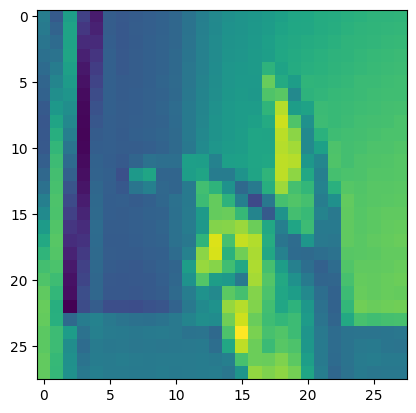

In [ ]:
plt.imshow(x_train[0].reshape(28,28))


**Start Building the CNN model**

In [ ]:
# Import all the nessasary libs and packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
# Defining batch size, epochs and number of classes which is 24
batch_size = 128
num_classes = 24
epochs = 50

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, train_labels, validation_data = (x_val, val_labels), epochs=epochs, batch_size=batch_size)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 69s 389ms/step - accuracy: 0.0976 - loss: 3.0902 - val_accuracy: 0.5741 - val_loss: 1.5036
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 83s 398ms/step - accuracy: 0.5654 - loss: 1.3795 - val_accuracy: 0.8204 - val_loss: 0.7088
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 81s 394ms/step - accuracy: 0.7732 - loss: 0.7883 - val_accuracy: 0.9071 - val_loss: 0.4792
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 79s 378ms/step - accuracy: 0.8675 - loss: 0.5457 - val_accuracy: 0.9548 - val_loss: 0.3453
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9201 - loss: 0.4076 - val_accuracy: 0.9785 - val_loss: 0.2539
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 84s 393ms/step - accuracy: 0.9412 - loss: 0.3324 - val_accuracy: 0.9934 - val_loss: 0.2132
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 80s 385ms/step - accuracy: 0.9634 - loss: 0.2770 - val_accuracy: 0.9927 - val_loss: 0.1924
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 82s 386ms/step - accuracy: 0.9747 - loss: 0

In [ ]:
model_pkl_file = "/content/drive/My Drive/Applied AI/Coursework/gestureRecognitionModel-1.pkl"

In [ ]:
import pickle

# save the iris classification model as a pickle file

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
import pickle
#Load pickle file
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,066 (2.77 MB)

 Trainable params: 241,688 (944.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 483,378 (1.84 MB)

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, test_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

86/86 - 2s - 27ms/step - accuracy: 0.9996 - loss: 0.0459
Test Accuracy: 1.00


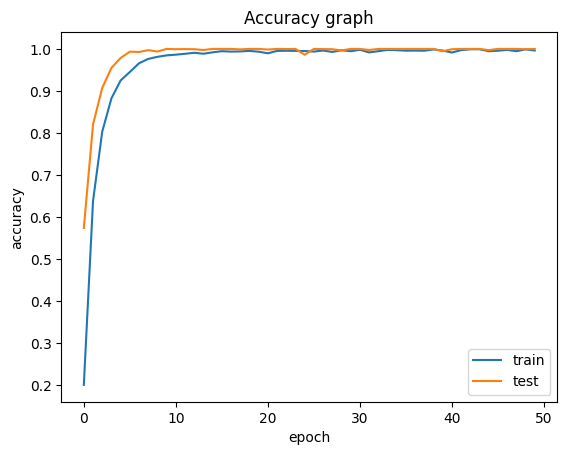

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy graph")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

plt.show()

Initial testing stage

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, test_labels, verbose=2)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

86/86 - 2s - 20ms/step - accuracy: 0.9996 - loss: 0.0459

Test Loss: 0.0459
Test Accuracy: 0.9996


In [ ]:
# Generate predictions for the test set
predictions = model.predict(x_test)

# Convert predictions to class labels
predicted_labels = predictions.argmax(axis=1)
true_labels_index = test_labels.argmax(axis=1)

print("Predicted Labels: ", predicted_labels[:5])
print("True Labels: ", true_labels_index[:5])


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Predicted Labels:  [19 17 23  6 15]
True Labels:  [19 17 23  6 15]


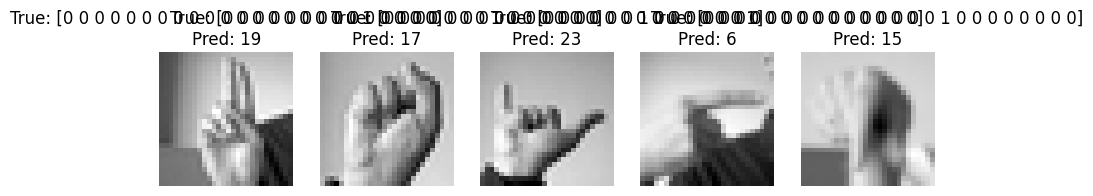

In [ ]:
def plot_predictions(images, true_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.show()

# Plot predictions for the first 5 test images
plot_predictions(x_test, test_labels, predicted_labels, num_images=5)

In [ ]:
test_labels = test_df['label']
test_df.drop('label', axis = 1, inplace = True)
test_images = test_df.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [ ]:
y_pred = model.predict(test_images)


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred.round())

0.8721416620189626

In [ ]:
print(test_labels.shape)
print(y_pred.shape)

(7172, 24)
(7172, 24)


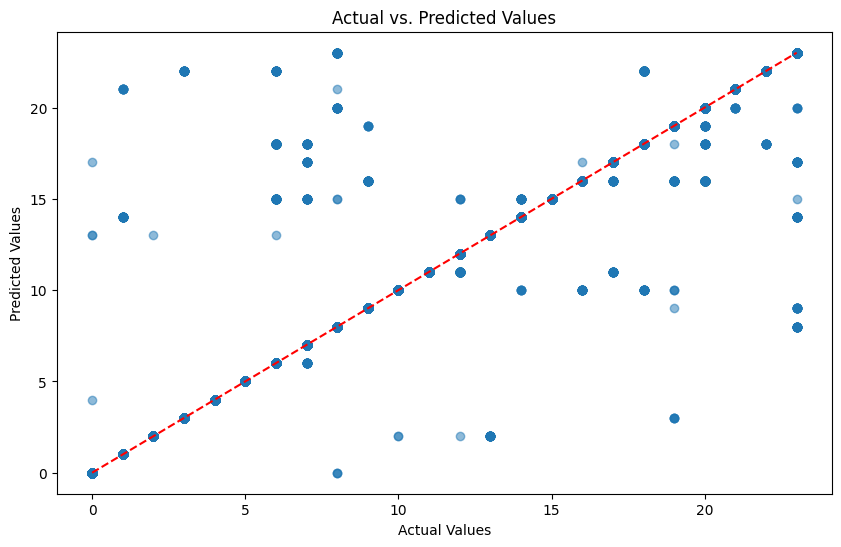

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(test_labels.argmax(axis=1), y_pred.argmax(axis=1), alpha=0.5)  # Scatter plot for actual vs predicted
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Get the range for the diagonal line
min_val = min(min(test_labels.argmax(axis=1)), min(y_pred.argmax(axis=1)))
max_val = max(max(test_labels.argmax(axis=1)), max(y_pred.argmax(axis=1)))

# Plot the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

In [ ]:
predictions = model.predict(x_test)
print("Example Probabilities:", predictions[:5])

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Example Probabilities: [[1.98061359e-10 2.23041367e-04 5.71611813e-10 1.34658171e-06
  9.69204161e-10 1.07645959e-09 4.45590006e-12 1.60264461e-13
  3.29493055e-09 2.24488819e-08 1.09630982e-09 3.38994859e-08
  2.24554757e-08 4.05349887e-09 4.80030390e-11 6.25240526e-09
  8.25516327e-06 1.45705556e-07 1.47341623e-08 9.99734163e-01
  1.56686929e-06 3.13508099e-05 5.82615165e-08 7.08761527e-14]
 [1.18173438e-03 8.38981418e-09 8.53224602e-09 1.03431032e-03
  2.98911100e-03 1.87362534e-08 1.20096086e-11 1.17771104e-09
  6.97677251e-07 4.94491323e-11 1.56443891e-09 4.76128841e-03
  4.06510517e-04 6.35694778e-06 5.50351487e-10 1.25183840e-06
  1.65309877e-09 9.89618361e-01 3.13943482e-10 7.91895660e-10
  2.69783251e-10 7.52756852e-13 3.35799971e-10 3.80753562e-07]
 [2.84964568e-16 6.78580847e-21 8.99911709e-18 2.21966195e-12
  3.08806404e-22 8.26092126e-18 8.47713011e-09 1.93335325e-07
  5.27828703e-13 1.53521626e-10 6.00031656e-12 2.06359907e-17
  6.5

In [58]:
from google.colab import files
uploaded = files.upload()


Saving letterY.jpeg to letterY.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Predicted Class: 3


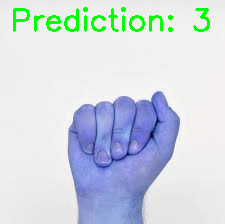

In [48]:
from PIL import Image
import cv2

# Load the image
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)
image = np.array(image)

# Preprocess the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (28, 28))
gray = gray.reshape(1, 28, 28, 1)
gray = gray / 255.0  # Normalize

# Perform Prediction
prediction = model.predict(gray)
predicted_class = np.argmax(prediction)

# Display the result
print(f'Predicted Class: {predicted_class}')

# Show the image with prediction
cv2.putText(image, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Letter: G


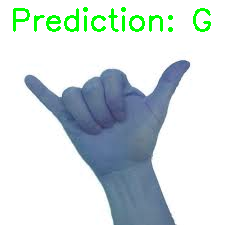

In [59]:
from PIL import Image
import cv2
import numpy as np

# Define the class-to-label mapping
class_mapping = {
    0: 'A',  1: 'B',  2: 'C',  3: 'D',  4: 'E',  5: 'F',  6: 'G',  7: 'H',
    8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P',
    15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X',
    23: 'Y'
}

# Load the uploaded image (adjust this part based on the image you've uploaded)
image_path = list(uploaded.keys())[0]  # Replace with your actual image path
image = Image.open(image_path)
image = np.array(image)

# Preprocess the image (convert to grayscale and resize to model's input size)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (28, 28))
gray = gray.reshape(1, 28, 28, 1)
gray = gray / 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(gray)
predicted_class = np.argmax(prediction)  # Get the index of the highest prediction

# Map the class index to the letter
predicted_letter = class_mapping.get(predicted_class, 'Unknown')

# Display the predicted letter
print(f'Predicted Letter: {predicted_letter}')

# Show the image with the predicted letter
cv2.putText(image, f'Prediction: {predicted_letter}', (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
!pip install --upgrade opencv-python

In [ ]:
import cv2
vid = cv2.VideoCapture(1)
if not vid.isOpened():
    raise IOError("Cannot open webcam")
while(True):
      ret, frame = vid.read()
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      gray = cv2.resize(gray, (28, 28), interpolation= cv2.INTER_AREA)
      gray = gray.reshape(1, 28, 28, 1)
      gray = gray/255.0
      prediction = model.predict(gray)
      predicted_class = np.argmax(prediction)
      cv2.putText(frame, f"Prediction: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

      cv2.imshow('Real-time Prediction', frame)


# Release the camera and close windows
vid.release()
cv2.destroyAllWindows()

OSError: Cannot open webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from PIL import Image
import io

# JavaScript to capture video with stop functionality
def video_stream():
    js = Javascript('''
        let stream;
        let video;
        let isStreaming = false;

        async function videoStream() {
            if (isStreaming) return;
            isStreaming = true;

            const div = document.createElement('div');
            document.body.appendChild(div);

            video = document.createElement('video');
            div.appendChild(video);
            video.style.width = '640px';
            video.style.height = '480px';

            stream = await navigator.mediaDevices.getUserMedia({ video: true }).catch(error => {
                alert('Camera permission denied.');
                throw error;
            });
            video.srcObject = stream;
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            const stopButton = document.createElement('button');
            stopButton.innerText = 'Stop Webcam';
            stopButton.onclick = stopStream;
            div.appendChild(stopButton);

            // Continuously capture frames
            while (isStreaming) {
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                const dataURL = canvas.toDataURL('image/jpeg', 0.8);
                google.colab.kernel.invokeFunction('notebook.captureFrame', [dataURL], {});
                await new Promise(resolve => setTimeout(resolve, 100));
            }
        }

        function stopStream() {
            isStreaming = false;
            if (stream) {
                const tracks = stream.getTracks();
                tracks.forEach(track => track.stop());
            }
            if (video) {
                video.srcObject = null;
                video.remove();
            }
        }
    ''')
    display(js)
    eval_js('videoStream()')

# Decode frame from JavaScript
def decode_frame(data):
    binary = b64decode(data.split(',')[1])
    image = Image.open(io.BytesIO(binary))
    return np.array(image)

# Gesture Prediction (Example using a CNN model)
def predict_gesture(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (28, 28))
    gray = gray / 255.0
    gray = gray.reshape(1, 28, 28, 1)

    prediction = model.predict(gray)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Callback to process frames
def process_frame(data):
    frame = decode_frame(data)

    # Convert to grayscale and resize for model input
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
    gray = gray.reshape(1, 28, 28, 1)
    gray = gray / 255.0

    # Perform prediction
    prediction = model.predict(gray)
    predicted_class = np.argmax(prediction)

    # Display prediction on frame
    cv2.putText(frame, f"Prediction: {predicted_class}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame using cv2_imshow (Colab)
    cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Corrected for Colab display

# Register the frame capture callback
from google.colab import output
output.register_callback('notebook.captureFrame', process_frame)

# Start the video stream
video_stream()


<IPython.core.display.Javascript object>

In [ ]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 32.6 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io
from google.colab.patches import cv2_imshow
import mediapipe as mp

# Initialize MediaPipe Hands model
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.5)

# JavaScript to capture video
def video_stream():
    js = Javascript('''
        let stream;
        let video;
        let isStreaming = false;

        async function videoStream() {
            if (isStreaming) return;
            isStreaming = true;

            const div = document.createElement('div');
            document.body.appendChild(div);

            video = document.createElement('video');
            div.appendChild(video);
            video.style.width = '640px';
            video.style.height = '480px';

            stream = await navigator.mediaDevices.getUserMedia({ video: true }).catch(error => {
                alert('Camera permission denied.');
                throw error;
            });
            video.srcObject = stream;
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            const stopButton = document.createElement('button');
            stopButton.innerText = 'Stop Webcam';
            stopButton.onclick = stopStream;
            div.appendChild(stopButton);

            // Continuously capture frames
            while (isStreaming) {
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                const dataURL = canvas.toDataURL('image/jpeg', 0.8);
                google.colab.kernel.invokeFunction('notebook.captureFrame', [dataURL], {});
                await new Promise(resolve => setTimeout(resolve, 100));
            }
        }

        function stopStream() {
            isStreaming = false;
            if (stream) {
                const tracks = stream.getTracks();
                tracks.forEach(track => track.stop());
            }
            if (video) {
                video.srcObject = null;
                video.remove();
            }
        }
    ''')
    display(js)
    eval_js('videoStream()')

# Decode frame from JavaScript
def decode_frame(data):
    binary = b64decode(data.split(',')[1])
    image = Image.open(io.BytesIO(binary))
    return np.array(image)

# Gesture Prediction (Using CNN Model)
def predict_gesture(hand_roi):
    gray = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (28, 28)) / 255.0
    gray = gray.reshape(1, 28, 28, 1)

    prediction = model.predict(gray)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Process each frame for hand detection and prediction
def process_frame(data):
    frame = decode_frame(data)

    # Convert frame to RGB (MediaPipe uses RGB)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Calculate bounding box around hand
            h, w, _ = frame.shape
            x_min = w
            y_min = h
            x_max = y_max = 0

            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                x_max = max(x, x_max)
                y_max = max(y, y_max)

            # Draw rectangle around the detected hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Extract hand ROI for prediction
            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.shape[0] > 0 and hand_roi.shape[1] > 0:
                predicted_class = predict_gesture(hand_roi)

                # Display prediction
                cv2.putText(frame, f"Prediction: {predicted_class}", (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the processed frame
    cv2_imshow(frame)

# Register callback
from google.colab import output
output.register_callback('notebook.captureFrame', process_frame)

# Start video stream
video_stream()


<IPython.core.display.Javascript object>

In [46]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from PIL import Image
import io
import base64

# Load Trained Model
# from tensorflow.keras.models import load_model
# model = load_model('/content/drive/My Drive/Applied AI/Coursework/gestureRecognitionModel-1.pkl')

# JavaScript to Capture Webcam
def video_stream():
    js = Javascript('''
        let video;
        let stream;
        let div;
        let isStreaming = false;

        async function videoStream() {
            if (isStreaming) return;
            isStreaming = true;

            div = document.createElement('div');
            document.body.appendChild(div);

            video = document.createElement('video');
            div.appendChild(video);
            video.style.width = '640px';
            video.style.height = '480px';

            stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            const stopButton = document.createElement('button');
            stopButton.innerText = 'Stop Webcam';
            stopButton.onclick = stopStream;
            div.appendChild(stopButton);

            while (isStreaming) {
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                const dataURL = canvas.toDataURL('image/jpeg', 0.8);
                google.colab.kernel.invokeFunction('notebook.captureFrame', [dataURL], {});
                await new Promise(resolve => setTimeout(resolve, 100));
            }
        }
        function stopStream() {
            isStreaming = false;
            if (stream) {
                const tracks = stream.getTracks();
                tracks.forEach(track => track.stop());
            }
            if (video) {
                video.srcObject = null;
                video.remove();
            }
        }
    ''')
    display(js)
    eval_js('videoStream()')

# Decode JavaScript Frame
def decode_frame(data):
    binary = base64.b64decode(data.split(',')[1])
    image = Image.open(io.BytesIO(binary))
    return np.array(image)

# Gesture Prediction and Bounding Box
def process_frame(data):
    frame = decode_frame(data)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = cv2.flip(frame, 1)  # Mirror effect like webcam

    # Define ROI (Region of Interest)
    x_start, y_start = 320, 100
    x_end, y_end = 620, 400

    roi = frame[y_start:y_end, x_start:x_end]
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_roi = cv2.resize(gray_roi, (28, 28))
    gray_roi = gray_roi.reshape(1, 28, 28, 1) / 255.0

    # Prediction
    result = np.argmax(model.predict(gray_roi))

    # Overlay Prediction
    cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), (255, 0, 0), 5)
    cv2.putText(frame, f'Prediction: {result}', (x_start - 30, y_start - 20),
                cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

    # Show Live Feed
    cv2_imshow(frame)

# Register Frame Callback
from google.colab import output
output.register_callback('notebook.captureFrame', process_frame)

# Start Webcam
video_stream()


<IPython.core.display.Javascript object>

MessageError: NotAllowedError: Permission denied

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'